<a href="https://colab.research.google.com/github/OnurcanKoken/TensorFlow_Workshops_Colab_General_Usage/blob/master/Oversampling/Oversampling_Male_Infertility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Veri Dengeleme - Oversampling**

# 1. Kütüphaneleri ve Verileri Tanımlayalım

In [ ]:
# Mounting Google Drive locally
# Import Google Drive Files and the Dataset
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Selection of Tensorflow version
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
# Import the Libraries that will be used
import os
import cv2
import glob
import keras
import random 
from random import randint
import numpy as np
from numpy import save
from numpy import expand_dims
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import ndimage, misc
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import itertools
import shutil
import warnings
!pip install -q keras
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# save the model
import h5py

# load back the model
from keras.models import load_model

# import the necessary library to resize
from skimage.transform import resize

# library to convert 224 x 224 grayscale to rgb
from skimage.color import gray2rgb

In [ ]:
# Load the Dataset

# 1000 x 128 x 128
x_128_train = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/x_128_train.npy'
np_x_128_train = np.load(x_128_train)

# 240 x 128 x 128
x_128_valid = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/x_128_valid.npy'
np_x_128_valid = np.load(x_128_valid)

# 300 x 128 x 128
x_128_test = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/x_128_test.npy'
np_x_128_test = np.load(x_128_test)

In [ ]:
# Load Acrosome Labels

# for 1000 Samples
y_acrosome_train = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/y_acrosome_train.npy'
np_y_acrosome_train = np.load(y_acrosome_train)

# for 240 Samples
y_acrosome_valid = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/y_acrosome_valid.npy'
np_y_acrosome_valid = np.load(y_acrosome_valid)

# for 300 Samples
y_acrosome_test = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/y_acrosome_test.npy'
np_y_acrosome_test = np.load(y_acrosome_test)


Convert the trains to 4th dimention and decrease shapes of validation and test sets from 128 pixel to 64 pixel

In [ ]:
# convert train set to 1000 x 128 x 128 x 1
np_x_128_train_s = np.resize(np_x_128_train, (1000,128,128,1))

# convert validation set to 240 x 128 x 128 x 1
np_x_128_valid_s = np.resize(np_x_128_valid, (240,64,64,1))

# convert test set to 300 x 128 x 128 x 1
np_x_128_test_s = np.resize(np_x_128_test, (300,64,64,1))

# 2. Prepare the Data

şu anda bu bölümü kullanmıyoruz, onun yerine kendimiz s0 s1 listleri oluşturup onları kullanacağız

In [ ]:
# dataset paths
train_path = '/content/drive/MyDrive/AI/MHSMA_Data/train'
valid_path = '/content/drive/MyDrive/AI/MHSMA_Data/valid'
test_path = '/content/drive/MyDrive/AI/MHSMA_Data/test'

In [ ]:
# use ImageDataGenerator and flow_from_directory to create batches
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['normal', 'abnormal'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['normal', 'abnormal'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['normal', 'abnormal'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# 2. Prepare the Data for Oversampling

Let us first seperate S_0 and S_1
where S_0 contains positive/normal samples and S_1 contains negative/abnormal samples

In [ ]:
# save and seperate training images
# class 0, positive, normal
# class 1, negative, abnormal
S_0 = []
S_1 = []
i = 0
p = 0
n = 0
for i in range(1000): # number of images
  
  img = np_x_128_train[i]
  img = Image.fromarray(img)
  list_of_pixels = list(img.getdata())
  img_i = str(i)
  label = np_y_acrosome_train[i]
  #img_list = img.tolist()
  if label == 0:
    S_0.append(list_of_pixels) # be careful it returns None, so do not assign it
    # print(img_i + ' is saved' + ' as ' + str(label))
    p = p + 1
  elif label == 1:
    S_1.append(list_of_pixels)
    # print(img_i + ' is saved' + ' as ' + str(label))
    n = n + 1

# print(str(n) + ' abnormal, ' + str(p) + ' normal ' + ' images are saved')
# expected result is: "301 abnormal 699 normal images are saved"


In [ ]:
print(len(S_0), len(S_0[0])) # results 699 16384

699 16384


How to get back the original img from a list - no need to run this part

In [ ]:
  img = np_x_128_train[0]
  img = Image.fromarray(img)
  list_of_pixels = list(img.getdata())

In [ ]:
print(img.mode, img.size)

L (128, 128)


In [ ]:
#im2 = Image.new(img.mode, img.size)
im2 = Image.new('L', (128,128))
im2.putdata(list_of_pixels)

# 3. Data Augmentation 

Notice that we need to convert the image list to an image format (128x128)

In [ ]:
# rotation
import scipy
# rotate image [0,360) degree by nearest-neighbor algorithm
def rotate_img(image, degree):

    image = scipy.ndimage.interpolation.rotate(image, degree, reshape = False, mode='nearest')

    return image

# this one is an alternative to rotate by using the Image Data Generator
# rotate image [0,360) degree by nearest-neighbor algorithm
def alternative_rotate_img(image, degree):

    datagen = ImageDataGenerator(rotation_range = degree) 
    img_rotate = img_to_array(image) 
    img_rotate = img_rotate.reshape((1, ) + img_rotate.shape)  

    i=0
    for img_batch in datagen.flow(img_rotate, batch_size=1):
      for img_rotate in img_batch:
          img_rotate = np.squeeze(img_rotate, axis = 2)
          img_rotate = np.asarray(img_rotate)
          #plt.imshow(img_rotate, cmap='gray', vmin=0, vmax=255)
          #plt.show()
          i=i+1    
      if i >= 1: # limits the number of rotated images
          break

    return img_rotate


In [ ]:
# shift
# Shifting Left
def shift_left(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for i in range(HEIGHT, 1, -1):
    for j in range(WIDTH):
      if (i < HEIGHT-pxl):
        image[j][i] = image[j][i-pxl]
  return image

# Shifting Right
def shift_right(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for j in range(WIDTH):
    for i in range(HEIGHT):
      if (i < HEIGHT-pxl):
        image[j][i] = image[j][i+pxl]
  return image

# Shifting Up
def shift_up(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for j in range(WIDTH):
    for i in range(HEIGHT):
      if (j < WIDTH - pxl and j > pxl):
        image[j][i] = image[j+pxl][i]
      #else: # this can be used instead of overwriting on the image
        # image[j][i] = 1
  return image

# Shifting Down
def shift_down(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for j in range(WIDTH, 1, -1):
    for i in range(HEIGHT):
      if (j < HEIGHT - pxl and j > pxl):
        image[j][i] = image[j-pxl][i]
  return image

# Shift randomly
def shift_all(image):

  v = random.randint(0, 1)
  if v == 1:
    image = shift_up(image, random.randint(0, 5))
  if v == 0:
    image = shift_down(image, random.randint(0, 5))

  h = random.randint(0, 1)
  if h == 1:
    image = shift_right(image, random.randint(0, 5))
  if h == 0:
    image = shift_left(image, random.randint(0, 5))
  
  return image


In [ ]:
# flip vertical and/or horizontal
def flip_vh(image):
  h = random.randint(0, 1)
  y = random.randint(0, 1)
  if (h == 1):
    image = np.flipud(image) # up down
  if (y == 1):
    image = np.fliplr(image) # left right
  return image

In [ ]:
# exp^log(1.25) brigthness
def brigth1_25(image):
  x = np.log10(1.25)
  y = random.uniform(-x,x)
  image = (np.exp(y))*image
  return image

In [ ]:
# SizeAndCut: 128x128 to 64x64
def SizeAndCut(img):
  new_img = np.zeros((64,64))
  for i in range(0,96):
   for j in range(0,96):
     if 32 <= i <= 95:
       if 32 <= j <= 95:
          new_img[i-32,j-32] = img[i,j]

  return new_img

In [ ]:
# convert 1D list to 2D image
def pixel_to_image(image_pixel):

  im2 = Image.new('L',(128,128))
  im2.putdata(image_pixel)
  return im2


In [ ]:
# normalize img by substruct mean of it and divide by 255
def norm_img(img):
  img_norm = (img - np.mean(img)) / 255
  return img_norm

In [ ]:
def Data_Augmentation(image):

  # convert 1D list to 2D image
  image = pixel_to_image(image)

  # rotate [0,360)
  image = rotate_img(image, random.randint(0, 359))

  # shift +-5 horizontal or vertical
  image = shift_all(image)

  # flip horizontal and/or vertical
  image = flip_vh(image)

  # brightness
  image = brigth1_25(image)

  # 128x128 to 64x64
  image = SizeAndCut(image)

  # normalization
  image = norm_img(image)

  return image

# 4. Generate Mini Batch

In [ ]:
def Generate_Mini_Batch(S_0, S_1, epochs = 64):
  B = [] # empty list for images
  B_label = [] # empty list for labels
  i_0 = 0 # last sample index of S0
  i_1 = 0 # last sample index of S1
  
  # generate 64 images randomly
  for i in range(64): # i = 0 to 63
    c = randint(0,1)

    # class 0 positive normal                                                           
    if c == 0:
      if i_0 == 0:
        # shuffle S0                                                           
        random.shuffle(S_0)
      # send original img and get generated one
      img_x = Data_Augmentation(S_0[i_0])

    # class 1 negative abnormal
    if c == 1:
      if i_1 == 0:
        # shuffle S1                                                           
        random.shuffle(S_1)
      # send original img and get generated one
      img_x = Data_Augmentation(S_1[i_1])      

    # append generated image to B list                                 
    B.append(img_x)                   
    # save the label of generated image                                         
    B_label.append(c)
    
    # increase the index of S0 and S1
    # when index exceed the length of list
    # go back to beginning
    if c == 0:
      i_0 = (i_0 + 1) % len(S_0) # mod operation        
    else:
      i_1 = (i_1 + 1) % len(S_1)  

  # return generated B list and its label list                 
  return B, B_label
    

# 5. Check - Generate_Mini_Batch & Data_Augmentation

No need to run this part!

Let us try the generate_mini_batch and data_augmentation functions

In [ ]:
# obtain the generated images and labels
try_x, try_y = Generate_Mini_Batch(S_0, S_1, epochs = 64)


In [ ]:
B, B_label = try_x, try_y

In [ ]:
shape(try_x)

length of B list is 64 
length of B_label list is 64 
shape of an image is (64, 64) 
label (0 is normal, 1 is abnormal) of this image is 0


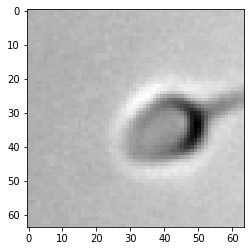

In [ ]:
# obtain the generated images and labels
B, B_label = Generate_Mini_Batch(S_0, S_1, epochs = 64)
# copy and plot the image
plt.imshow((B[17]).copy(), cmap = 'gray')
print("length of B list is", len(B), 
      "\nlength of B_label list is", len(B_label),
      "\nshape of an image is", (B[17]).shape, 
      "\nlabel (0 is normal, 1 is abnormal) of this image is", B_label[17] )


In [ ]:
img_1.shape

(64, 64)

In [ ]:
len(try_y)


64

In [ ]:
len(try_x)

64

In [ ]:
print("length of B list is", len(B), ", length of B_label list is", len(B_label))
print("shape of an image is", (B[42]).shape, ", label (0 is normal, 1 is abnormal) of this image is", B_label[42] )

length of B list is 64 , length of B_label list is 64
shape of an image is (64, 64) , label (0 is normal, 1 is abnormal) of this image is 0


In [ ]:
# convert the floating list of image to a np array
img_1 = np.asarray(img_1)

In [ ]:
# size and shape of an image
print(img_1.size)
print(img_1.shape)

4096
(64, 64)


In [ ]:
# convert np array to an image
img_1 = Image.fromarray(img_1)
print(img_1.mode, img_1.size)
print(len(try_y))
print(len(try_x))

F (64, 64)
64
64


# Check normalization - Failed

In [ ]:
valid_batches = create_valid_batches()   
img_batch, img_label = valid_batches.next()

Found 240 images belonging to 2 classes.


In [ ]:
img_batch[1]

array([[[0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275],
        ...,
        [0.10219999, 0.05184706, 0.02478431],
        [0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275]],

       [[0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275],
        ...,
        [0.10219999, 0.05184706, 0.02478431],
        [0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275]],

       [[0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275],
        ...,
        [0.10219999, 0.05184706, 0.02478431],
        [0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275]],

       ...,

       [[0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0.04792549, 0.02086275],
        [0.09827843, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


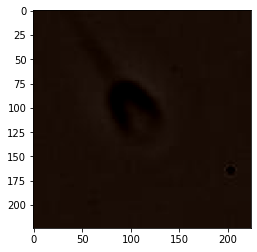

In [ ]:
img_batch_img = (img_batch[1]).copy() 
img_batch_img = img_batch_img*1
#plt.imshow(img_batch_img, cmap = 'gray')
plt.imshow(img_batch_img)

# Check Normalization - 2

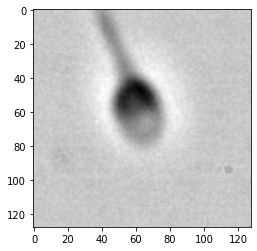

In [ ]:
img_128_1 = (np_x_128_train[1]).copy()
im_128_1 = Image.fromarray(norm_img(img_128_1))
arr = np.asarray(im_128_1)
plt.imshow(arr, cmap='gray')
plt.show()


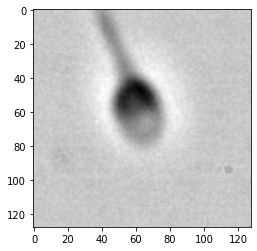

In [ ]:
img_128_1 = (np_x_128_train[1]).copy()
im_128_1 = Image.fromarray((img_128_1))
arr = np.asarray(im_128_1)
plt.imshow(arr, cmap='gray')
plt.show()


# 6. Model_1 Simple CNN


In [ ]:
# create the 2nd model, Simple CNN Model

model_1 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(64,64,1)), # 64 x 64 x 3 ?
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [ ]:
# summarize model_1 | fine-tuned vgg16 model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32770     
Total params: 51,586
Trainable params: 51,586
Non-trainable params: 0
__________________________________________________

In [ ]:
## insert
## transfer learning
## vgg16
## here
## !!!

In [ ]:
# before compiling our model,
# let us define
# precision, recall, f0.5, f1
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f05_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    beta_square = 0.5**2
    return (1+beta_square)*((precision*recall)/(beta_square*precision+recall+K.epsilon()))

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    # beta_square is equal to 1 here
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# this time "binary_crossentropy" is used
# model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', f05_m, f1_m, precision_m, recall_m])

In [ ]:
# this time "categorical_crossentropy" is used
#model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f05_m, f1_m, precision_m, recall_m])
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 7. Model_2 VGG16 - Transfer Learning - Fine Tuning

Daha önceden indirmiştik, onu doğrudan yüklüyorum.

In [ ]:
# load the vgg16_model
import h5py
from keras.models import load_model
vgg16_model = load_model("/content/drive/MyDrive/AI/Male_Infertility_Assessment/Models/vgg16_model.h5")
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Kendi modelimizi oluşturuyoruz, son 3 katmanı eğitilebilir hale getireceğim.

In [ ]:
# get all the layers until the last one
model_2 = Sequential()
for layer in vgg16_model.layers[:-4]:
    model_2.add(layer)


In [ ]:
# freeze all the layers
for layer in model_2.layers:
    layer.trainable = False

In [ ]:
# add the last 4 layers as you desire, I have used the same structure
model_2.add(Flatten())
model_2.add(Dense(units = 4096, activation = 'relu')) # fully connected layers
model_2.add(Dense(units = 4096, activation = 'relu'))

# add the last layer to seperate normal and abnormal classes
model_2.add(Dense(units=2, activation='softmax'))

In [ ]:
# summarize model_2 | fine-tuned vgg16 model
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# 8. Convert Training Dataset to Batch

In [ ]:
import os
import glob

def clear_folders():

  files = glob.glob('/content/drive/MyDrive/AI/MHSMA_Data_Temp/train/normal/*')
  for f in files:
      os.remove(f)

  files = glob.glob('/content/drive/MyDrive/AI/MHSMA_Data_Temp/train/abnormal/*')
  for f in files:
      os.remove(f)

def file_images(x,y):

  # class 0, positive, normal
  # class 1, negative, abnormal
  i = 0
  p = 0
  n = 0
  for i in range(200): # number of images

    img = x[i]
    img = Image.fromarray(img)

    # convert 'F' to JPEG 
    # img = Image.fromarray(img)
    img = img.convert('L')  

    img_i = str(i)
    label = y[i]

    if label == 0:
      img.save('/content/drive/MyDrive/AI/MHSMA_Data_Temp/train/normal/' + img_i + '.jpg','JPEG')
      # print(img_i + ' is saved' + ' as ' + str(label))
      p = p + 1
    elif label == 1:
      img.save('/content/drive/MyDrive/AI/MHSMA_Data_Temp/train/abnormal/' + img_i + '.jpg','JPEG')
      # print(img_i + ' is saved' + ' as ' + str(label))
      n = n + 1

  print(str(n) + ' abnormal, ' + str(p) + ' normal ' + ' images are saved')
  # expected result is: "? abnormal ? normal images are saved"

  return 0

def create_batch():
  
  # dataset path
  train_path = '/content/drive/MyDrive/AI/MHSMA_Data_Temp/train'
  train_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
      .flow_from_directory(directory=train_path, target_size=(224,224), classes=['normal', 'abnormal'], batch_size=64, shuffle=True)

  return train_batch

def train_to_batch(x,y):

  # clear the folders
  clear_folders()
  
  # save and seperate training images
  c = file_images(x,y)

  if c == 0:
    # print("images saved")
    print(" ")
  else:
    print("we have a problem")
  
  # create a batch
  train_batch = create_batch()

  return train_batch

def create_valid_batches():
  valid_path = '/content/drive/MyDrive/AI/MHSMA_Data/valid'
  valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
      .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['normal', 'abnormal'], batch_size=64, shuffle=True)

  return valid_batches


# Evaluation Metrics

In [ ]:
# before compiling our model,
# let us define
# precision, recall, f0.5, f1
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f05_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    beta_square = 0.5**2
    return (1+beta_square)*((precision*recall)/(beta_square*precision+recall+K.epsilon()))

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    # beta_square is equal to 1 here
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 8. Train & Validate The Model with Oversampling & Data Augmentation

First Training to see if it works

In [ ]:
#loss min is our main purpose
#S_0 an S_1 lists are determined                                               

#model = model_1 # simple cnn
model_100 = model_2 # vgg16 - transfer learning

# this time "categorical_crossentropy" is used
model_100.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f05_m, f1_m, precision_m, recall_m])

loss_min = 0.3 # let us initialize the min loss as 2            #????????????????
valid_batches = create_valid_batches()                        #????????????????

for i in range(100): # this is going to be equal to 10.000    #????????????????

  print(i, "\n")

  # trains are used instead of batches
  x, y = Generate_Mini_Batch(S_0,S_1,64)

  # x = np.resize(x,(64,64,64,1))                             #????????????????

  x = np.array(x)
  y = np.array(y)

  train_batch = train_to_batch(x,y)
  

  # training part
  # result = model.fit(x, y, batch_size=64, epochs=1, verbose=1, validation_data = (np_x_128_valid_s, np_y_acrosome_valid), validation_batch_size=64, shuffle=True) 
  # result = model.fit(x, y, batch_size=64, epochs=1, verbose=1, shuffle=True) 
  # train the model with training and validation datasets
  result_100 = model_100.fit(x=train_batch,
      steps_per_epoch=len(train_batch),
      validation_data=valid_batches,
      validation_steps=len(valid_batches),
      batch_size = 64,
      epochs=3)

  # get the loss function result on validation set
  # loss_current = result_100.history['val_loss'] 

  # for any need;
  # train_loss = result_100.history['loss']
  # loss_current = train_loss
  # train_acc  = result_100.history['accuracy']
  val_acc    = result_100.history['val_accuracy']
  loss_current = val_acc
   
  print(loss_current, "\n")

  # update current loss
  # continue

  if loss_current[-1] > loss_min:
    loss_min = loss_current[-1]
    # save and update the model parameters                                                
    # let us save the vgg16_model
    model_100.save("/content/drive/MyDrive/AI/Male_Infertility_Assessment/Models/oversamp_6_model.h5")
    print("the model is saved")


Found 240 images belonging to 2 classes.
0 

107 abnormal, 93 normal  images are saved
 
Found 200 images belonging to 2 classes.
Epoch 1/3
4/4 [==============================] - 239s 78s/step - loss: 1.3008 - accuracy: 0.5008 - f05_m: 0.5000 - f1_m: 0.5000 - precision_m: 0.5000 - recall_m: 0.5000 - val_loss: 0.7803 - val_accuracy: 0.6625 - val_f05_m: 0.6641 - val_f1_m: 0.6641 - val_precision_m: 0.6641 - val_recall_m: 0.6641
Epoch 2/3
4/4 [==============================] - 208s 59s/step - loss: 1.1180 - accuracy: 0.6588 - f05_m: 0.6724 - f1_m: 0.6724 - precision_m: 0.6724 - recall_m: 0.6724 - val_loss: 12.8030 - val_accuracy: 0.2750 - val_f05_m: 0.2760 - val_f1_m: 0.2760 - val_precision_m: 0.2760 - val_recall_m: 0.2760
Epoch 3/3
4/4 [==============================] - 209s 59s/step - loss: 1.0992 - accuracy: 0.6812 - f05_m: 0.7016 - f1_m: 0.7016 - precision_m: 0.7016 - recall_m: 0.7016 - val_loss: 1.9373 - val_accuracy: 0.3833 - val_f05_m: 0.3867 - val_f1_m: 0.3867 - val_precision_m: 0.

In [ ]:
# validation loss min is our main purpose here
# the focus can be validation accuracy, too
# S_0 an S_1 lists are determined                                               

# "categorical_crossentropy" is used
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f05_m, f1_m, precision_m, recall_m])

loss_min = 2 # let us initialize the min loss as 2           
valid_batches = create_valid_batches()                        

for i in range(100): # number of iterations 

  # trains are used instead of batches
  x, y = Generate_Mini_Batch(S_0,S_1,64)
                      
  x = np.array(x)
  y = np.array(y)

  train_batch = train_to_batch(x,y)

  # train the model with training and validation datasets
  his = model.fit(x=train_batch,
      steps_per_epoch=len(train_batch),
      validation_data=valid_batches,
      validation_steps=len(valid_batches),
      batch_size = 64,
      epochs=3)

  # get the loss function result on validation set
  loss_current = his.history['val_loss'] 

  # for any need;
  # train_loss = his.history['loss']
  # train_acc  = his.history['accuracy']
  # val_acc = his.history['val_accuracy'] 

  # update loss
  if loss_current[-1] < loss_min:
    loss_min = loss_current[-1]
    # save and update the model parameters                                                
    model.save("/MyDrive/.../oversamp_model.h5")
    print("the model is saved")

In [ ]:
# validation loss min is our main focus
# S_0 an S_1 lists are determined                                               

# vgg16 - transfer learning model
# "categorical_crossentropy" is used
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f05_m, f1_m, precision_m, recall_m])

loss_min = 0.3 # let us initialize the min loss as 2      
valid_batches = create_valid_batches()                       

for i in range(100): # this is going to be equal to 10.000  

  # generate mini-batch by S0 and S1 lists
  x, y = Generate_Mini_Batch(S_0,S_1,64)

  # convert list to np.array fromat
  x = np.array(x)
  y = np.array(y)

  # create the training batch with np.arrays
  train_batch = train_to_batch(x,y)
  
  # training part
  # train the model with training and validation datasets
  result = model.fit(x=train_batch,
      steps_per_epoch=len(train_batch),
      validation_data=valid_batches,
      validation_steps=len(valid_batches),
      batch_size = 64,
      epochs=1)

  # get the loss function result on validation set
  loss_current = result.history['val_loss'] 

  # check and update the minimum loss
  if loss_current[-1] > loss_min:
    loss_min = loss_current[-1]
    # save the model parameters                                                
    model.save("/content/drive/MyDrive/AI/Male_Infertility_Assessment/Models/oversamp_6_model.h5")
    print("the model is saved")


# 9. Test the Model

In [ ]:
# train the model with training and validation datasets
#model_1.fit(x=train_batches,
#    steps_per_epoch=len(train_batches),
#    validation_data=valid_batches,
#    validation_steps=len(valid_batches),
#    epochs=1,
#    verbose=2
#)

In [ ]:
# use the model to predict outputs of test data
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

# 10. Visualize the Predictions

In [ ]:
# define a function to visualize the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # Normalization can be applied
    # normalize = True
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, round(cm[i, j],2),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# get the predictions and true values

# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data, test labels
test_labels = test_batches.classes 

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       213
           1       0.54      0.39      0.45        87

    accuracy                           0.73       300
   macro avg       0.66      0.63      0.64       300
weighted avg       0.71      0.73      0.71       300



In [ ]:
# use the confusion matrix plotting function
cm = confusion_matrix(y_true = test_labels, y_pred = y_pred)

In [ ]:
# check the label if everything is alright
test_batches.class_indices

{'abnormal': 1, 'normal': 0}

Confusion matrix, without normalization
[[184  29]
 [ 53  34]]


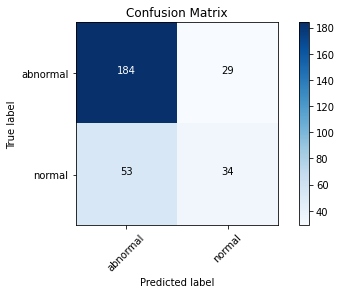

In [ ]:
# plot the confusion matrix without normalization
cm_plot_labels = ['normal', 'abnormal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Normalized confusion matrix
[[0.86384977 0.13615023]
 [0.6091954  0.3908046 ]]


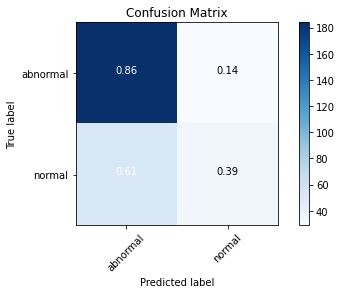

In [ ]:
# plot the normalized confusion matrix
plot_confusion_matrix(cm=cm, normalize = True, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# calculate the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_true = test_labels
y_pred = y_pred
a = accuracy_score(y_true, y_pred)
p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)
f1 = fbeta_score(y_true, y_pred, beta=1.0)
f05 = fbeta_score(y_true, y_pred, beta=0.5)

print('Result: accuracy = %.3f, precision = %.3f, recall = %.3f, f1_score = %.3f, f0.5_score = %.3f' % (a, p, r, f1, f05))


Result: accuracy = 0.727, precision = 0.540, recall = 0.391, f1_score = 0.453, f0.5_score = 0.501


# 11. References

Add layer to model

- https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/

- https://keras.io/guides/sequential_model/

- https://keras.io/api/layers/core_layers/

Conversion Image - List

- https://stackoverflow.com/questions/12062920/how-do-i-create-an-image-in-pil-using-a-list-of-rgb-tuples


Return history of training in Keras:

- https://stackoverflow.com/questions/36952763/how-to-return-history-of-validation-loss-in-keras#:~:text=According%20to%20Keras%20documentation%2C%20the,successive%20losses%20and%20other%20metrics.

- https://keras.io/getting_started/faq/#how-can-i-record-the-training-validation-loss-accuracy-at-each-epoch

- https://keras.io/guides/customizing_what_happens_in_fit/


Shuffle two lists:

- https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order

Clear Folder:

- https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder

